In [1]:
import h5py
import numpy as np

SAMPLE_FREQ = 256
SAMPLE_SIZE = SAMPLE_FREQ // 2
WINDOW_POST_RECOVERY = (0, SAMPLE_FREQ * 3)
WINDOW_PRE_RECOVERY = (SAMPLE_FREQ * -7, SAMPLE_FREQ * -1)

def read_dataset(filepath):
    features = {}

    with h5py.File(filepath) as hf:
        data = [None] * len(hf)
        i = 0
        for dset in hf.values():
            columns = dset.attrs['columns']
            for col in columns:
                if col not in features:
                    features[col] = len(features)
            column_numbers = [features[col] for col in columns]

            data[i] = dset[:], dset.attrs['recovery'], column_numbers
            i += 1
            
    return data, [feat for (feat, _) in sorted(features.items(), key=lambda x: x[1])]


def get_window_samples(data, window, sample_size):
    curr, stop = window
    end = len(data)
    if curr < 0:
        curr += end
        stop += end
    while curr < 0:
        curr += sample_size
    
    samples = []
    while end >= curr + sample_size <= stop:
        samples.append(data[curr:curr + sample_size])
        curr += sample_size

    return samples


def get_samples(data, sample_size):
    parsed = [None] * len(data)
    num_samples = 0
    
    for i in range(len(data)):
        dset, recovery_ix, features = data[i]
        pre = get_window_samples(dset[:recovery_ix], WINDOW_PRE_RECOVERY, sample_size)
        post = get_window_samples(dset[recovery_ix:], WINDOW_POST_RECOVERY, sample_size)
        num_samples += len(pre) + len(post)
        parsed[i] = pre, post, features
        
    return parsed, num_samples


def samples_to_tensors(samples, data_shape):
    num_samples, sample_size, num_features = data_shape
    X = np.full((num_samples, sample_size, num_features), np.nan)
    Y = np.zeros((num_samples, 1))

    i = 0
    for pre, post, features in samples:
        for window, label in [(pre, 0), (post, 1)]:
            i_next = i + len(window)
            if i == i_next:
                continue
            X[i:i_next, :, features] = window
            Y[i:i_next] = label
            i = i_next
        
    return X, Y


def get_data(filepath, sample_size):
    data, features = read_dataset(filepath)
    samples, num_samples = get_samples(data, sample_size)
    X, Y = samples_to_tensors(samples, (num_samples, sample_size, len(features)))
    return X, Y, features

In [2]:
import bct
import pandas as pd
from scipy import stats
from mne.time_frequency import psd_array_multitaper

def get_eeg_data(X_raw, features):
    features_eeg = [col for col in features if 'EEG_' in col]
    X_eeg = np.nan_to_num(X_raw[:, :, np.isin(features, features_eeg)], 0)
    # For most of our EEG feature extractors, it's easier to reason about the computation
    # if the array is (epochs, channels, time)
    X_eeg = X_eeg.swapaxes(2, 1)
    return X_eeg, [col.replace('EEG_', '') for col in features_eeg]

def get_zero_crossings(data):
    is_2d = len(data.shape) == 2
    if is_2d:
        data = np.array([data])
    positive = data > 0
    crossings = np.bitwise_xor(positive[:, :, 1:], positive[:, :, :-1])
    return crossings[0] if is_2d else crossings

def extract_time_features(X):
    enrichers = [
        ("mean", np.mean, {}),
        ("var", np.var, {}),
        ("stddev", np.std, {}),
        ("skew", stats.skew, {}),
        ("kurtosis", stats.kurtosis, {}),
        ("zero_xings", lambda x, **kwargs: np.count_nonzero(get_zero_crossings(x), **kwargs), {}),
        ("p2p", lambda x, **kwargs: x.max(**kwargs) - x.min(**kwargs), {}),
        ("aauc", lambda x, **kwargs: np.trapz(np.abs(x), **kwargs), {"dx": 1/SAMPLE_FREQ })
    ]
    X_enriched = np.concatenate(
        [enrich(X, axis=-1, **kwargs) for (_, enrich, kwargs) in enrichers],
        axis=-1,
    )
    
    return X_enriched, [feat for (feat, _, _) in enrichers]

def extract_frequency_features(X):
    psds, freqs =  psd_array_multitaper(X, SAMPLE_FREQ, fmax=110)
    bands = [
        ["delta", 0],
        ["theta", 4],
        ["alpha", 8],
        ["beta", 14],
        ["gamma1", 30],
        ["gamma2", 65],
    ]
    num_bands = len(bands)
    
    total = psds.sum(axis=-1)
    total_no_zeros = np.where(total > 0, total, 1)
    for i in range(num_bands):
        band = bands[i]
        _, fmin = band
        fmax = (freqs[-1] + 1) if i == (num_bands - 1) else bands[i + 1][1]
        band[1] = psds[:, :, (freqs >= fmin) & (freqs < fmax)].sum() / total_no_zeros
    bands.append(["energy", total])
    
    # TODO: Coefficients of 7-level Discrete Wavelet Transform decomposition

    X_enriched = np.concatenate([band for (_, band) in bands], axis=-1)
    
    return X_enriched, [band for (band, _) in bands]

def extract_epoch_correlation_features(X, lag_size, num_lags):
    # Since correlation is symmetric, we only need half the lags
    # C_xy(-t) = C_yx(t)
    num_lags = num_lags // 2 + 1
    X_lagged = np.full((*X.shape, num_lags), np.nan)
    X_lagged[:, :, 0] = X - X.mean(axis=-1, keepdims=True)
    
    for i in range(1, num_lags):
        lag = lag_size * i
        X_lagged[:, :-lag, i] = X_lagged[:, lag:, 0]
        
    # pd.DataFrame.corr() expects each signal to be a column, not a row
    X_lagged = X_lagged.swapaxes(2, 1).reshape(-1, X.shape[1]).T
    # corr[i, t1, j, t2] represents correlation of channel i lagged by t1 with channel j lagged by t2
    corr = pd.DataFrame(X_lagged).corr().to_numpy().reshape(X.shape[0], num_lags, X.shape[0], num_lags)
    corr = np.nan_to_num(corr, 0)
    
    channels = np.arange(X.shape[0])
    autocorr = corr[channels, 0, channels].reshape(channels.size, -1)
    decorr_t = np.argmax(get_zero_crossings(autocorr), axis=-1).astype(np.float)
    decorr_t *= lag_size / SAMPLE_FREQ
    
    corr = np.abs(corr).max(axis=(-1, 1))
    graph = extract_epoch_graph_features(corr)
    corr = corr[np.tril_indices(corr.shape[0], -1)]
    
    return np.concatenate([corr, decorr_t, *graph])


def extract_epoch_graph_features(W):
    L = bct.weight_conversion(W, 'lengths')
    L[W == 0] = np.inf
    D, _ = bct.distance_wei(L)

    l, eff, ecc, radius, diameter = bct.charpath(D, include_infinite=False)

    return [
        bct.clustering_coef_wu(W),
        bct.efficiency_wei(W, local=True),
        bct.betweenness_wei(L),
        ecc,
        [l, eff, radius, diameter],
    ]
    
    
def extract_correlation_features(X, channels):
    lag_size = 4
    num_lags = 2 ** int(np.log2(0.5 * X.shape[2] / lag_size))
    
    num_epochs = X.shape[0]
    num_channels = len(channels)
    num_features = (
        + (num_channels * (num_channels - 1)) // 2  # cross-correlation
        + num_channels                              # decorrelation-time
        + 4 * num_channels                          # graph (local)
        + 4                                         # graph (global)
    )
    X_corr = np.zeros((num_epochs, num_features))
    
    for i in range(num_epochs):
        X_corr[i] = extract_epoch_correlation_features(X[i], lag_size, num_lags)
        
    features_corr = [f"{channels[i]}_{col2}_corr" for i in range(num_channels - 1) for col2 in channels[i+1:]]
    features_corr += [f"{col}_decor_t" for col in channels]
    features_corr += [f"{col}_{feat}" for feat in ['clust_coef', 'eff', 'centrality', 'ecc'] for col in channels]
    features_corr += ['charpath', 'eff', 'radius', 'diameter']
    
    return X_corr, features_corr

def extract_eeg_features(X_raw, features):
    X_eeg, features_eeg = get_eeg_data(X_raw, features)
    
    X_time, features_time = extract_time_features(X_eeg)
    X_freq, features_freq = extract_frequency_features(X_eeg)
    X_corr, features_corr = extract_correlation_features(X_eeg, features_eeg)
    
    X_enriched = np.concatenate([X_time, X_freq, X_corr], axis=-1)
    features = features_time + features_freq
    features = [f"{feat}_{enrich}" for enrich in features for feat in features_eeg]
    features += features_corr
    
    return X_enriched, features

In [3]:
DATA_FILE_TRAINING = '../data/epochs/1572178629-1578573846-train.h5'
tmp_X_raw, tmp_Y, tmp_features = get_data(DATA_FILE_TRAINING, SAMPLE_SIZE * 2)

In [4]:
tmp_X, tmp_features_eeg = extract_eeg_features(tmp_X_raw, tmp_features)
print(tmp_X.shape)
print(tmp_features_eeg)

    Using multitaper spectrum estimation with 7 DPSS windows
(7216, 114)
['TP9_mean', 'AF7_mean', 'AF8_mean', 'TP10_mean', 'Right_AUX_mean', 'TP9_var', 'AF7_var', 'AF8_var', 'TP10_var', 'Right_AUX_var', 'TP9_stddev', 'AF7_stddev', 'AF8_stddev', 'TP10_stddev', 'Right_AUX_stddev', 'TP9_skew', 'AF7_skew', 'AF8_skew', 'TP10_skew', 'Right_AUX_skew', 'TP9_kurtosis', 'AF7_kurtosis', 'AF8_kurtosis', 'TP10_kurtosis', 'Right_AUX_kurtosis', 'TP9_zero_xings', 'AF7_zero_xings', 'AF8_zero_xings', 'TP10_zero_xings', 'Right_AUX_zero_xings', 'TP9_p2p', 'AF7_p2p', 'AF8_p2p', 'TP10_p2p', 'Right_AUX_p2p', 'TP9_aauc', 'AF7_aauc', 'AF8_aauc', 'TP10_aauc', 'Right_AUX_aauc', 'TP9_delta', 'AF7_delta', 'AF8_delta', 'TP10_delta', 'Right_AUX_delta', 'TP9_theta', 'AF7_theta', 'AF8_theta', 'TP10_theta', 'Right_AUX_theta', 'TP9_alpha', 'AF7_alpha', 'AF8_alpha', 'TP10_alpha', 'Right_AUX_alpha', 'TP9_beta', 'AF7_beta', 'AF8_beta', 'TP10_beta', 'Right_AUX_beta', 'TP9_gamma1', 'AF7_gamma1', 'AF8_gamma1', 'TP10_gamma1', 

In [55]:
DATA_FILE_TRAINING = '../data/epochs/1572178629-1578573846-train.h5'
X, Y, FEATURES = get_data(DATA_FILE_TRAINING, SAMPLE_SIZE)

NUM_FEATURES = len(FEATURES)
NUM_SAMPLES = 6

print('Number of samples in set:', len(X))
print('All seen features:', FEATURES)

Number of samples in set: 14445
All seen features: ['EEG_TP9', 'EEG_AF7', 'EEG_AF8', 'EEG_TP10', 'EEG_Right_AUX', 'ACC_X', 'ACC_Y', 'ACC_Z', 'GYRO_X', 'GYRO_Y', 'GYRO_Z', 'PPG_PPG1', 'PPG_PPG2', 'PPG_PPG3']


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, BatchNormalization, Conv1D

def add_ic_layer(model, name, dropout=0.2):
    model.add(BatchNormalization(name=f"{name}_bn"))
    if dropout:
        model.add(Dropout(dropout, name=f"{name}_dropout"))

def add_lstm_layer(model, name, params):
    ic_params = params.pop("ic_params", {})
    model.add(LSTM(name=name, **params))
    add_ic_layer(model, name, **ic_params)
    
def get_lstm_model(
    input_shape,
    lstm_layers,
    conv1d_params=None,
    dense_units=32,
    dense_dropout=0.2,
):
    model = Sequential()
    
    if conv1d_params is not None:
        name = "conv1d"
        model.add(Conv1D(name=name, input_shape=input_shape, **conv1d_params))
        model.add(Activation("relu", name=f"{name}_relu"))
        add_ic_layer(model, name)
    
    num_lstm_layers = len(lstm_layers)
    for i in range(num_lstm_layers):
        name = f"lstm_{i + 1}"
        params = lstm_layers[i]
        if i == 0 and conv1d_params is None:
            params["input_shape"] = input_shape
        if i < num_lstm_layers - 1:
            params["return_sequences"] = True
        add_lstm_layer(model, name, params)
    
    name = "dense"
    model.add(Dense(dense_units, activation="relu", name=name))
    add_ic_layer(model, name, dense_dropout)
    
    model.add(Dense(1, activation='sigmoid', name="output"))
    
    return model

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                233600    
_________________________________________________________________
lstm_1_bn (BatchNormalizatio (None, 32)                128       
_________________________________________________________________
lstm_1_dropout (Dropout)     (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_bn (BatchNormalization (None, 32)                128       
_________________________________________________________________
dense_dropout (Dropout)      (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                

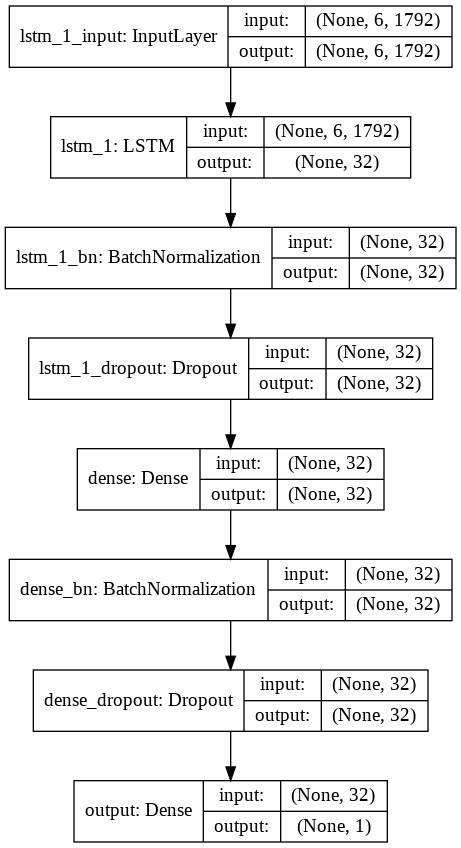

In [4]:
from keras.utils import plot_model

model_one = get_lstm_model(
    (NUM_SAMPLES, NUM_FEATURES * SAMPLE_SIZE),
    [
        { "units": 32, "dropout": 0.2, "ic_params": { "dropout": 0.2 } },
    ],
    conv1d_params=None,
)
model_one.summary()
plot_model(model_one, to_file='model_one.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 64)             475392    
_________________________________________________________________
lstm_1_bn (BatchNormalizatio (None, 6, 64)             256       
_________________________________________________________________
lstm_1_dropout (Dropout)     (None, 6, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
lstm_2_bn (BatchNormalizatio (None, 32)                128       
_________________________________________________________________
lstm_2_dropout (Dropout)     (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)               

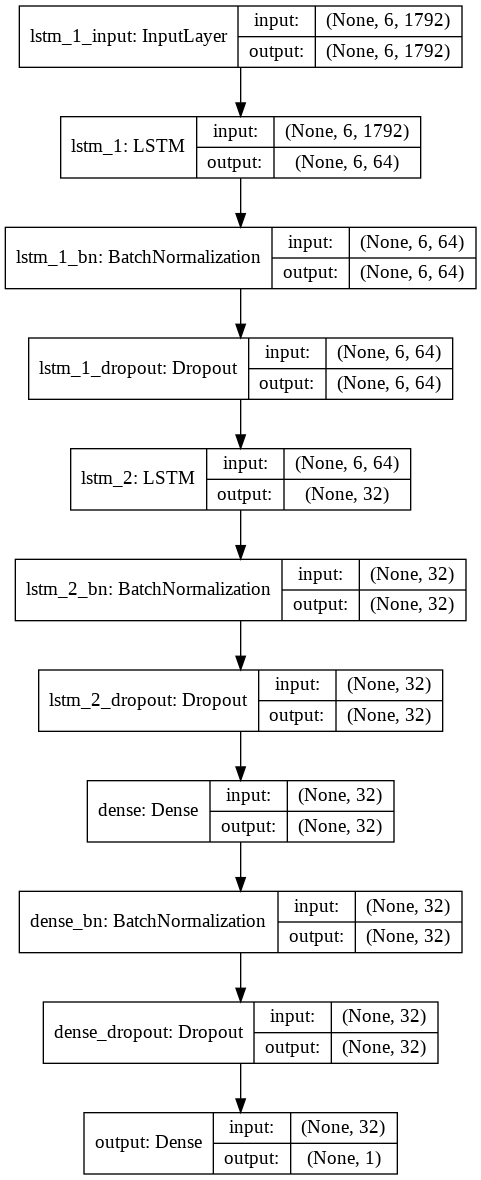

In [5]:
from keras.utils import plot_model

model_two = get_lstm_model(
    (NUM_SAMPLES, NUM_FEATURES * SAMPLE_SIZE),
    [
        { "units": 64, "dropout": 0.2, "ic_params": { "dropout": 0.2 } },
        { "units": 32, "ic_params": { "dropout": 0.2 } },
    ],
    conv1d_params=None,
)
model_two.summary()
plot_model(model_two, to_file='model_two.png', show_shapes=True, show_layer_names=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 189, 128)          27008     
_________________________________________________________________
conv1d_relu (Activation)     (None, 189, 128)          0         
_________________________________________________________________
conv1d_bn (BatchNormalizatio (None, 189, 128)          512       
_________________________________________________________________
conv1d_dropout (Dropout)     (None, 189, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 189, 64)           49408     
_________________________________________________________________
lstm_1_bn (BatchNormalizatio (None, 189, 64)           256       
_________________________________________________________________
lstm_1_dropout (Dropout)     (None, 189, 64)          

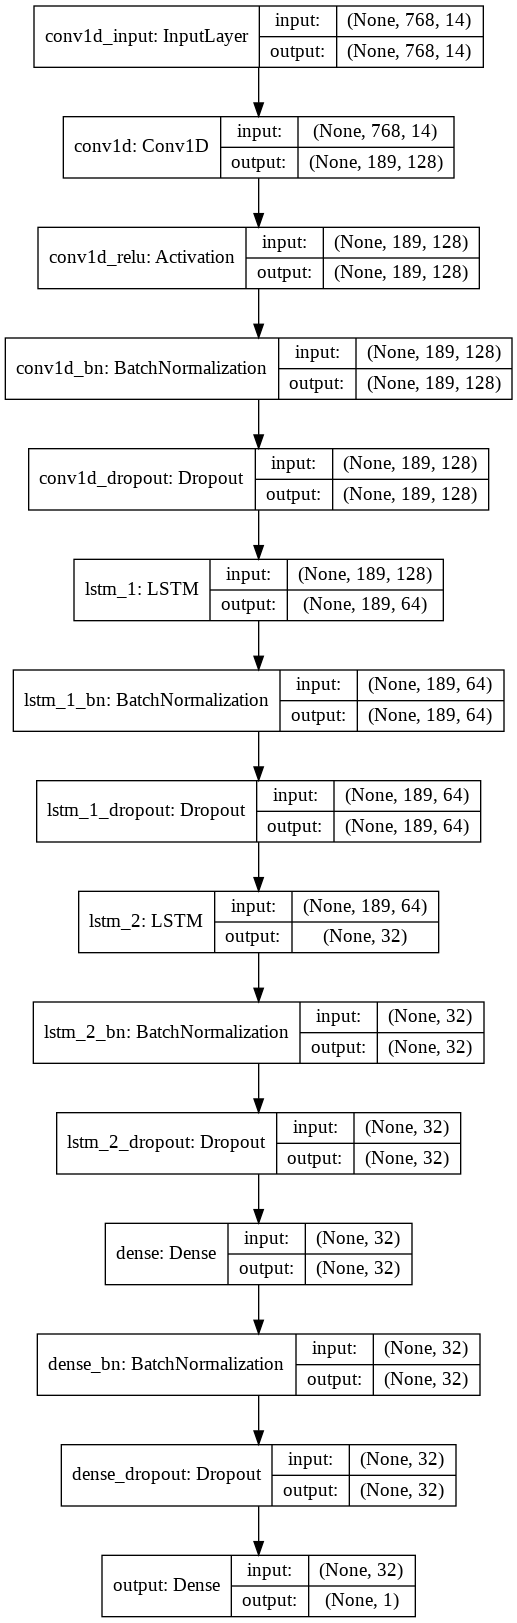

In [6]:
from keras.utils import plot_model

model_three = get_lstm_model(
    (NUM_SAMPLES * SAMPLE_SIZE, NUM_FEATURES),
    [
        { "units": 64, "dropout": 0, "ic_params": { "dropout": 0.2 } },
        { "units": 32, "ic_params": { "dropout": 0.2 } },
    ],
    conv1d_params={"filters": 128, "kernel_size": 15, "strides": 4},
)
model_three.summary()
plot_model(model_three, to_file='model_three.png', show_shapes=True, show_layer_names=True)

In [7]:
from keras.optimizers import Adam

LEARNING_RATE=0.1
BETA_ONE=0.9
BETA_TWO=0.999
DECAY=0.01

def reshape_data_for_model(X_in, Y_in, input_shape):
    X_out = []
    for label in [0, 1]:
        X_label = X_in[(Y_in == label).flatten()]
        rem = X_label.shape[0] % NUM_SAMPLES
        if rem > 0:
            X_label = X_label[:-rem]
        reshape = (-1, *input_shape)
        X_out.append(X_label.reshape(reshape))
    miss_size = X_out[0].shape[0]
    X_out = np.concatenate(X_out)
    Y_out = np.ones((X_out.shape[0], 1))
    Y_out[:miss_size] = 0
    return np.nan_to_num(X_out), Y_out

def compile_model(
    model,
    learning_rate=0.01,
    beta_one=0.9,
    beta_two=0.999,
    decay=0.01,
):
    opt = Adam(learning_rate, beta_one, beta_two, decay)
    model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])

def train_model(model, X, Y, epochs=100, batch_size=32, shuffle=True, **kwargs):
    input_shape = model.get_layer(index=0).input_shape[1:]
    compile_model(model, LEARNING_RATE, BETA_ONE, BETA_TWO, DECAY)
    
    return model.fit(
        *reshape_data_for_model(X, Y, input_shape),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=shuffle,
        **kwargs,
    )

In [8]:
model_one_history = train_model(model_one, X, Y, epochs=1)

Epoch 1/1
2608/2608 [==============================] - 2s 765us/step - loss: 0.6918 - accuracy: 0.6273
